# Valassis Assessment
Author: Brenton Mallen


In [1]:
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')


## Problem Description

Valassis Digital has run a digital advertising campaign for one of our clients, targeting mobile users in the Southeast. The goal of the campaign was to drive conversions -- users pressing the ad and accepting our client's offer. To execute this campaign, we built an audience of target users based on historical information about the likelihood to convert.
 
Our campaigns are executed on real-time bidding (RTB) exchanges. Web pages or mobile apps submit bid requests to potential advertisers on these exchanges. If Valassis Digital sees a bid request for a user we want to target on a web page or mobile app we want to serve on, we will submit a bid for that advertising placement. If we submit the highest (or only) bid, we win the placement and serve an ad. Given that we have won and served the ad, a user then has the opportunity to convert.
 
We'd like you to take a look at the campaign's results to answer two primary questions:
 
1.       We ran two creatives (distinct ad designs) during the campaign: a baseline creative in line with our client's previous campaigns, and a new creative designed to increase conversions by more prominently displaying the offer to the user.  To do this, we assigned some users to a "test" group that received the new ad during the campaign.  Did the new creative increase conversions?

2.       We are equally likely to bid on any user at any time during a campaign.  Other advertisers have found success by "retargeting" users -- increasing the likelihood of a bid for users that have previously converted. Would retargeting have improved performance for this campaign?

#### Constants
Here are some constants used through the notebook

In [2]:
data_path = 'data'
bid_file = 'bid_requests.csv.gz'
user_file = 'user_attributes.csv.gz'


#### Helper Files
Here are some helper functions used to primarily reduce code reuse

In [3]:
def load_data(path: str, fname: str) -> pd.DataFrame:
    """Load a csv file into a dataframe"""
    return pd.read_csv(os.path.join(path, fname))

def convert_json_to_columns(df: pd.DataFrame, json_col: str) -> pd.DataFrame:
    """Convert a json column in dataframe into columns"""
    
    json_columns = pd.io.json.json_normalize(df[json_col].apply(json.loads))
    converted = (
        df.merge(pd.io.json.json_normalize(user_data.attributes.apply(json.loads)),
                 left_index=True,
                 right_index=True
                )
    ).drop(json_col, axis=1)
    return converted
    

## Load Data

In [4]:
bid_data = load_data(data_path, bid_file)
user_data = load_data(data_path, user_file)


### Initial Data Inspection
Let's take a look at the data and see what we're dealing with

In [5]:
bid_data.head()


,timestamp,user_id,bid,win,conversion
0,2017-01-01 00:00:01,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0
1,2017-01-01 00:00:02,26c5dca2512a4c7fe8810bd04191b1b3,0,0,0
2,2017-01-01 00:00:05,2121376a323507c01c5e92c39ae8ccd4,0,0,0
3,2017-01-01 00:00:12,fa6a0925d911185338b0acc93c66dc92,0,0,0
4,2017-01-01 00:00:13,4299f209da83da82b711f1d631cc607b,1,0,0


Looks like we can convert the timestamp to a date-time object

In [6]:
user_data.head()


,user_id,attributes
0,00003e3b9e5336685200ae85d21b4f5e,"{""age"": 33, ""gender"": ""F"", ""location"": ""FL"", ""..."
1,000053b1e684c9e7ea73727b2238ce18,"{""age"": 26, ""gender"": ""M"", ""location"": ""AL"", ""..."
2,00029153d12ae1c9abe59c17ff2e0895,"{""age"": 29, ""gender"": ""F"", ""location"": ""AR"", ""..."
3,0002ac0d783338cfeab0b2bdbd872cda,"{""age"": 29, ""gender"": ""M"", ""location"": ""SC"", ""..."
4,0004d0b59e19461ff126e3a08a814c33,"{""age"": 27, ""gender"": ""F"", ""location"": ""AR"", ""..."


Looks like we need to unpack the json column

#### Initial data cleaning
Here, the bid data will be converted to more useful data types and the user data will be unpacked

In [7]:
bid_data['timestamp'] = pd.to_datetime(bid_data['timestamp'])


In [8]:
user_data = convert_json_to_columns(user_data, 'attributes')


Let's look at the user data after the unpacking

In [9]:
user_data.head()


,user_id,age,gender,location,test
0,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1
1,000053b1e684c9e7ea73727b2238ce18,26,M,AL,1
2,00029153d12ae1c9abe59c17ff2e0895,29,F,AR,1
3,0002ac0d783338cfeab0b2bdbd872cda,29,M,SC,0
4,0004d0b59e19461ff126e3a08a814c33,27,F,AR,1


## Questions

**Question 1:**

What is the distribution of bid requests by user?

Please describe the distribution of requests for the users we targeted.

-----

/Users/brentonmallen/miniconda3/envs/valassis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Bid Request Count')

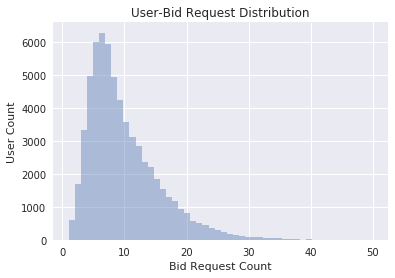

In [10]:
sns.distplot(bid_data.user_id.value_counts(), kde=False)
plt.title('User-Bid Request Distribution')
plt.ylabel('User Count')
plt.xlabel('Bid Request Count')


**Observation:**

The distribution of the number of requests has a long tail.  This means that there is a small percentage of users who have a much higher than average bid request count.  While I don't have a complete domain understanding of the nuance of how the data is collected or what goes into making a decision of deciding to place bid, I can make a couple of estimations.  The long tail could be an indication that there is a small group of users that are deamed highly valued (possibly known for a high conversion rate) which would lead to the desire to place bids on them, or it could be simply that there is a smaller population that recieves ads more frequently due to a higher browsing rate.

------

**Question 2:**

Is the test effective?
Were test users more likely to convert than control users?

-----

Let's first separate the two populations; the control and test users.

In [11]:
test_users = user_data[user_data.test == 1].user_id.tolist()
control_users = user_data[user_data.test == 0].user_id.tolist()


In [12]:
print(f"There are {len(test_users):,} users in the control group and {len(control_users):,} users in the test group")


There are 56,084 users in the control group and 43,916 users in the test group


In [13]:
test_bids = bid_data[bid_data.user_id.isin(test_users)]
control_bids = bid_data[bid_data.user_id.isin(control_users)]


Let's see how many bids were placed between the control and test campaigns

In [14]:
print(f"""There were {control_bids.bid.sum()} bids placed in the control campaign
and {test_bids.bid.sum()} bids placed in the test campaign""")



There were 130995 bids placed in the control campaign
and 168846 bids placed in the test campaign


Let's take a look at the percentage of users that were bid on between both campaigns

In [15]:
print(f"""{np.round((control_bids.groupby('user_id').bid.sum() > 0).value_counts(normalize=True)[1] * 100, decimals=3)} percent of users were bid on in the control campaign
and {np.round((test_bids.groupby('user_id').bid.sum() > 0).value_counts(normalize=True)[1] * 100, decimals=3)} percent of users were bid on in the test campaign
""")


97.102 percent of users were bid on in the control campaign
and 97.095 percent of users were bid on in the test campaign



To check campaign performance, we'll look at the conversion rate (percentage of users that converted given that a bid was placed) (assuming 1 means a conversion has happened)

In [16]:
control_conversion_rate = np.round(
    control_bids[control_bids.bid > 0].conversion.value_counts(normalize=True)[1] * 100,
    decimals = 3
)
test_conversion_rate = np.round(
    test_bids[test_bids.bid > 0].conversion.value_counts(normalize=True)[1] * 100,
    decimals = 3
)


In [17]:
print(f"Percentage of control users that converted: {control_conversion_rate}%")
print(f"Percentage of test users that converted: {test_conversion_rate}%")


Percentage of control users that converted: 2.079%
Percentage of test users that converted: 2.009%


**Observations:**

It looks the control and test campaigns were pretty similar in terms of scope.  They had a similar percentage of bids submitted and while more bids were submitted during the test campaign, there was a very slightly drop in the conversion rate in the test campaign.

This could be for a number of reasons. Potentially, but not limited to, the demographics of the control and test populations.

-----

**Question 3:**

Should we consider retargeting users that have previously converted?

Would retargeting users in this campaign have improved performance?

------

Let's take a look at the control and test population demographics

In [18]:
control_user_data = user_data[user_data.user_id.isin(control_users)]
test_user_data = user_data[user_data.user_id.isin(test_users)]

Let's compare the age distribution between the populations

In [19]:
control_user_data.age.describe()

count    43916.000000
mean        25.488364
std          4.599905
min         18.000000
25%         22.000000
50%         25.000000
75%         29.000000
max         33.000000
Name: age, dtype: float64

In [20]:
test_user_data.age.describe()

count    56084.000000
mean        25.493831
std          4.604352
min         18.000000
25%         21.000000
50%         25.000000
75%         29.000000
max         33.000000
Name: age, dtype: float64

**Observation:**

The age distribution between the two populations seems to be near identical, so a change in the targeted age group may have an impact on the conversion rate but another control sample would have to be collected.

Let's compare the gender distribution between the populations

In [21]:
control_user_data.gender.value_counts(normalize=True)

M    0.503256
F    0.496744
Name: gender, dtype: float64

In [22]:
test_user_data.gender.value_counts(normalize=True)

F    0.501177
M    0.498823
Name: gender, dtype: float64

**Observation:**

The gender distribution between the two populations seems to be near identical as well.

Let's compare the location between the populations

In [23]:
control_user_data.location.nunique()

11

In [24]:
test_user_data.location.nunique()

11

In [25]:
set(control_user_data.location.unique()) - set(test_user_data.location.unique())

set()

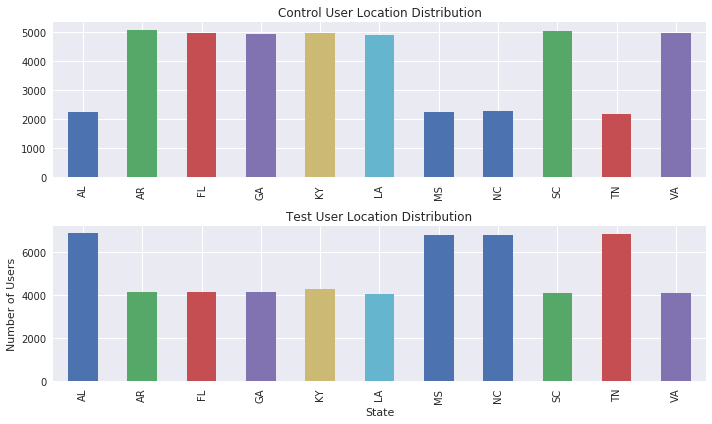

In [26]:
plt.figure(figsize=(10,6))
plt.subplot(211)
control_user_data.location.value_counts().sort_index().plot(kind='bar')
plt.title('Control User Location Distribution')
plt.subplot(212)
test_user_data.location.value_counts().sort_index().plot(kind='bar')
plt.title('Test User Location Distribution')
plt.ylabel('Number of Users')
plt.xlabel('State')
plt.tight_layout()

**Observation:**

It looks like location is where the two populations differ.  In fact, they look completely opposite of each other.  Meaning, the states that were drawn from heavily in the control campaign were not heavily drawn from in the test campaign. The same flip can be said about the lightly drawn states in the control campaign vs the test campaign.

I can't say whether retargeting would increase performance but it would indeed be a more direct comparision between the control and test campaigns if there was a similar distribution in locations.  This would reduce the variable to only the campaign itself and not the population.  Once the location distributions are similary between the two populations, then a statement can be made about the campaign performance in regards to conversion rate.